In [ ]:
import pandas as pd
import numpy as np
import math
from numpy.lib.npyio import savez_compressed
from itertools import permutations as perm
from itertools import combinations
from tqdm import tqdm

In [ ]:
#inputs

data_raw = pd.read_excel("/content/Voting_DataSet_08_Candidate.xlsx",sheet_name='Dataset with Remaing Pref')
NUM_candidates = 7
NUM_voters_col = "Number of voters"

import warnings
warnings.filterwarnings("ignore")

In [ ]:

def preprocess_and_imputation(data_raw):

  df_raw = data_raw.copy()
  df_raw = df_raw.drop(columns=['Unnamed: 9'])
  
  for ind,row in df_raw.iterrows():
  # print(ind)
    if type(row['Remaining Preferene'])==type("d"):
      #print(type(row['Remaining Preferene']),row['Remaining Preferene'])
      #print('y')
      impute_val = row['Remaining Preferene'].split(",")
    # print(impute_val)
      i = 0
      for col in df_raw.columns:
        #print(df_new.loc[ind,col])
        if col !="Remaining Preferene" and math.isnan(df_raw.loc[ind,col]):
          #print("y")
          df_raw.loc[ind,col] = int(impute_val[i])
          i = i+1

  df_raw = df_raw.drop(columns=['Remaining Preferene'])
  df_raw = df_raw.astype('int')
  df_raw.rename(columns={NUM_voters_col:"Number of voters"}, inplace=True)
  df_raw = df_raw.drop_duplicates()

  return df_raw

def make_7_cand_data(df_preprocessed):

  df_return = df_preprocessed.copy()
   
  for ind,row in df_return.iterrows():
    if row['Preference 8'] !=8:
    
      last_num = row['Preference 8']
      for col in df_return.columns:
        if col not in ['Number of voters','Preference 8']:
          if row[col] > last_num:
            df_return.loc[ind,col] = df_return.loc[ind,col] -1

  df_return = df_return.drop(columns=['Preference 8'])

  df_return = df_return.groupby(by=['Preference 1', 'Preference 2', 'Preference 3',
       'Preference 4', 'Preference 5', 'Preference 6', 'Preference 7'],as_index=False)['Number of voters'].sum()

  df_return = df_return.sample(frac=1)
  df_return = df_return.drop_duplicates()
  df_return.reset_index(drop=True,inplace=True)
  return df_return


def preference_to_candidate(preference_df):

  req = pd.DataFrame(columns=["Preference "+str(num) for num in range(1,NUM_candidates+1,1)])
  
  pre = list(preference_df.columns)
  pre.remove(NUM_voters_col)
  for ind,row in preference_df.iterrows():
    df_dict = {}
    for col in pre:
      prefer = int(col.split(" ")[1])

      cand = "Preference"+" " + str(row[col])
      df_dict[cand] = prefer

    #req = req.append(df_dict,ignore_index=True)
    req = pd.concat([req, pd.DataFrame.from_records([df_dict])]).reset_index(drop=True)

  req[NUM_voters_col] = preference_df[NUM_voters_col]

  return req


def ky_method(df_q,voters_col="Number of voters"):
 
  #if voters_col not in list(df.columns):
   # df = df.rename(columns={'No Of Voters':voters_col})
  
  df = df_q.copy()
  df['vote_percentage'] = df[voters_col]/(df[voters_col].sum())
  cand = list(df.columns)
  cand.remove(voters_col)
  cand.remove('vote_percentage')
  cand_orders = []
  scores = []
  for comb in perm(cand):
    comb_score = 0
    for pair in combinations(comb,2):
      temp_score = df[df[pair[0]] < df[pair[1]]]['vote_percentage'].sum()
      comb_score = comb_score + temp_score
    cand_orders.append(comb)
    scores.append(comb_score)

  df_return = pd.DataFrame()
  df_return['Preference'] = cand_orders
  df_return['Score'] = scores
  ret = df_return.sort_values(by=['Score'],ascending=False).reset_index().iloc[0,1]
  return ret


def generate_chunks(df,num_row_combined):   # generates chunks(group of 3 rows) of full data
  
  df_lst = []
  
  if df.shape[0] % num_row_combined != 0:
    remain = df.shape[0] % num_row_combined
    df = df.iloc[:df.shape[0]-remain,:]

  for ind in range(0,df.shape[0],num_row_combined):
    lower = ind
    higher = ind + num_row_combined

    df_chunk = df.iloc[lower:higher,:]

    df_lst.append(df_chunk)
    
  return df_lst

#generatin target for chunks
def gen_target_and_orders(df_lst):

  labels_lst, orders_lst = [], []
  for df in tqdm(df_lst):
  # borda_dict, t_taken = borda_count(df,5)
    res_tuple = ky_method(df,voters_col=NUM_voters_col)
    ky_orders_lst = [int(pre.split(' ')[1]) for pre in res_tuple]
  # borda_dict = borda_count(df_fill,5)
    label = int(res_tuple[0].split(" ")[1])
    labels_lst.append(label)
    orders_lst.append(ky_orders_lst)

  return labels_lst, orders_lst


def fe_process(df):   # does feature engineering

  return_df = pd.DataFrame()
  cols = list(df.columns)
  if NUM_voters_col in cols:
    cols.remove(NUM_voters_col)
    
  if "vote_percentage" in cols:
    cols.remove("vote_percentage")
  #dict_cand_avg = {}

  for col in cols:
    df_new = df[[NUM_voters_col,col]]
    df_new['avg_numerator'] = df_new[NUM_voters_col] * df_new[col]
    avg_num = np.sum(df_new['avg_numerator'])/np.sum(df_new[NUM_voters_col])

    #dict_cand_avg[col] = avg_num
    return_df[col] = [avg_num]

  return return_df

def get_final_df(df_lst,labels_lst,orders_lst):   # prepares final dataframe
  i = 0
  for df in df_lst:
    
    avg_df = fe_process(df)
    #avg_df['target'] = [lab]

    if i==0:
      final_df = avg_df.copy()

    else:
      final_df = final_df.append(avg_df)

    i = i+1
  
  final_df['target'] = labels_lst
  final_df['orders'] = orders_lst 
  final_df['orders'] = final_df['orders'].apply(lambda x:[int(num) for num in list(x) if num not in ["[","]",","," "]])
  if 'vote_percentag' in list(final_df.columns):
    final_df = final_df.drop(columns=['vote_percentage'])
    
  return final_df


In [ ]:
#function callls

df_preprocessed = preprocess_and_imputation(data_raw)
df_7cand_data = make_7_cand_data(df_preprocessed)
df_7cand_data = preference_to_candidate(df_7cand_data)
df_lst = generate_chunks(df_7cand_data,5)
labels_lst, orders_lst = gen_target_and_orders(df_lst)
df_final = get_final_df(df_lst,labels_lst,orders_lst)

In [ ]:
df_7cand_data.isnull().sum()

Preference 1        0
Preference 2        0
Preference 3        0
Preference 4        0
Preference 5        0
Preference 6        0
Preference 7        0
Number of voters    0
dtype: int64

In [1]:
df_final.to_csv("/content/drive/MyDrive/kevel_proj_final_df.csv",index=False)

NameError: ignored

In [2]:
import pandas as pd
df_final = pd.read_csv("/content/drive/MyDrive/kevel_proj_final_df.csv")

In [4]:
rename_dict = {}
for col in df_final.columns:
  if col not in ['vote_percentage','target','orders']:
    new_col = "Candidate " + col.split(" ")[1]
    rename_dict[col] = new_col

df_final_new = df_final.rename(columns=rename_dict)
df_final_new.head()


,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Candidate 5,Candidate 6,Candidate 7,vote_percentage,target,orders
0,1.647059,4.960784,1.960784,3.215686,3.921569,5.568627,6.725490,0.750096,1,"[1, 3, 4, 5, 2, 6, 7]"
1,3.250000,5.125000,5.125000,3.750000,3.500000,3.625000,3.625000,0.250000,1,"[1, 5, 6, 7, 4, 3, 2]"
2,3.142857,4.571429,3.428571,3.714286,5.857143,3.000000,4.285714,0.224490,1,"[1, 6, 3, 4, 7, 2, 5]"
3,3.454545,5.090909,2.727273,1.909091,4.636364,5.272727,4.909091,0.256198,4,"[4, 3, 1, 7, 5, 2, 6]"
4,2.500000,2.875000,2.375000,6.000000,3.125000,5.375000,5.750000,0.250000,2,"[2, 1, 3, 5, 6, 7, 4]"


# **Order prediction (Multi Winner) - Model Training**

In [ ]:
# train, test, split

from sklearn.model_selection import train_test_split

x = df_final.drop(columns=['target'])
y = df_final['target'].values

xtrain,xtest,ytrain_label,ytest_label = train_test_split(x,y,test_size=0.2,stratify=y,random_state=36)

ytrain_order = xtrain['orders'].values
ytest_order = xtest['orders'].values

xtrain = xtrain.drop(columns=['orders'])
xtest = xtest.drop(columns=['orders'])

def get_predicted_orders(model_proba):   #model_proba = model.predict_proba(x)
  
  pred_odr_lst = []
  for prob_lst in model_proba:

    temp_lst = [val+1 for val in np.argsort(-prob_lst)]

    pred_odr_lst.append(temp_lst)

  return pred_odr_lst

# preparing accuracy lists to calculate final mean accuracy
def get_accuracy(true_orders,pred_orders):

  acc_lst, tru_lst, mis_lst = [], [], []
  for tru,pred in zip(true_orders,pred_orders):
    #print(type(tru), type(pred))
    
    #tru = list(tru)
    #print(type(tru[0]), type(pred[0]))
    sub_array = np.array(tru) - np.array(pred)

    mis_predicted = np.count_nonzero(sub_array)
    truly_predicted = NUM_candidates - mis_predicted
    acc = (truly_predicted/NUM_candidates)*100
    acc_lst.append(acc)

  final_accu = np.mean(acc_lst)
  return final_accu

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# model training and experiments

def model_training_and_experiment(xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order):

  model_name, train_accuracy, test_accuracy = [],[],[]
  for key, model in {"Naive Bayes":MultinomialNB(), "Logistic regression":LogisticRegression(), 
                     "Decision tree":DecisionTreeClassifier(), "Random forest":RandomForestClassifier(),
                     "SVM":SVC(kernel='rbf', probability=True),"Boosting_model":GradientBoostingClassifier()}.items():
    model.fit(xtrain,ytrain_label)

    pred_proba_train = model.predict_proba(xtrain)
    pred_proba_test = model.predict_proba(xtest)

    pred_train_orders = get_predicted_orders(pred_proba_train)
    pred_test_orders = get_predicted_orders(pred_proba_test)
    
    model_acc_train = get_accuracy(ytrain_order,pred_train_orders)
    model_acc_test = get_accuracy(ytest_order,pred_test_orders)

    model_name.append(key)
    train_accuracy.append(model_acc_train)
    test_accuracy.append(model_acc_test)

  model_res_df = pd.DataFrame()
  model_res_df['Model'] = model_name
  model_res_df['Train_accuracy'] = train_accuracy
  model_res_df['Test_accuracy'] = test_accuracy

  print(tabulate(model_res_df, headers = 'keys', tablefmt = 'grid'))
  return

model_training_and_experiment(xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order)

+----+---------------------+------------------+-----------------+
|    | Model               |   Train_accuracy |   Test_accuracy |
+====+=====================+==================+=================+
|  0 | Naive Bayes         |          34.6397 |         32.3308 |
+----+---------------------+------------------+-----------------+
|  1 | Logistic regression |          52.9709 |         54.8872 |
+----+---------------------+------------------+-----------------+
|  2 | Decision tree       |          27.8761 |         22.0551 |
+----+---------------------+------------------+-----------------+
|  3 | Random forest       |          37.6738 |         28.5714 |
+----+---------------------+------------------+-----------------+
|  4 | SVM                 |          46.6498 |         43.1078 |
+----+---------------------+------------------+-----------------+
|  5 | Boosting_model      |          38.4956 |         34.8371 |
+----+---------------------+------------------+-----------------+


In [ ]:
# hyperparameter tunning for multi winner prediction
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

def hp_tunning_for_order_prediction(final_model,xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order):

  model = final_model
  param_dict = {'penalty':['l1', 'l2', 'elasticnet'],
                'C':[0.1,0.2,0.5,2,3,4,5,6,7,8,9],
                "fit_intercept":[True, False],
                'class_weight':['balanced',None]}

  para_combo_lst = list(ParameterGrid(param_dict))
  train_accuracy, test_accuracy = [],[]
  model_res_df = pd.DataFrame(columns=["C",'penalty','fit_intercept','class_weight'])

  for combo in para_combo_lst:
    
    if combo['penalty'] == "elasticnet":

      model = model.set_params(penalty=combo['penalty'],C=combo['C'],fit_intercept=combo['fit_intercept'],class_weight=combo['class_weight'],solver='saga',l1_ratio=0.4)
    else:
      model = model.set_params(penalty=combo['penalty'],C=combo['C'],fit_intercept=combo['fit_intercept'],class_weight=combo['class_weight'],solver='saga')

    model.fit(xtrain,ytrain_label)
    pred_proba_train = model.predict_proba(xtrain)
    pred_proba_test = model.predict_proba(xtest)

    pred_train_orders = get_predicted_orders(pred_proba_train)
    pred_test_orders = get_predicted_orders(pred_proba_test)
    
    model_acc_train = get_accuracy(ytrain_order,pred_train_orders)
    model_acc_test = get_accuracy(ytest_order,pred_test_orders)

   # model_name.append(key)
    train_accuracy.append(model_acc_train)
    test_accuracy.append(model_acc_test)
    model_res_df = model_res_df.append(combo,ignore_index=True)

  model_res_df['Train_accuracy'] = train_accuracy
  model_res_df['Validation_accuracy'] = test_accuracy

  model_res_df = model_res_df.sort_values(by=['Validation_accuracy',"Train_accuracy"],ascending=[False,False]).reset_index(drop=True)

  print(tabulate(model_res_df, headers = 'keys', tablefmt = 'grid'))
  return model_res_df

hp_tunning_df_for_order = hp_tunning_for_order_prediction(LogisticRegression(),xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order)

+-----+-----+------------+-----------------+----------------+------------------+-----------------------+
|     |   C | penalty    | fit_intercept   | class_weight   |   Train_accuracy |   Validation_accuracy |
+=====+=====+============+=================+================+==================+=======================+
|   0 | 0.1 | l1         | True            | balanced       |          60.4298 |               62.406  |
+-----+-----+------------+-----------------+----------------+------------------+-----------------------+
|   1 | 0.1 | l1         | False           | balanced       |          60.5563 |               61.1529 |
+-----+-----+------------+-----------------+----------------+------------------+-----------------------+
|   2 | 0.1 | l1         | True            |                |          60.5563 |               60.401  |
+-----+-----+------------+-----------------+----------------+------------------+-----------------------+
|   3 | 0.2 | elasticnet | True            |           

In [ ]:
def get_final_model(hp_tunning_df,xtrain,ytrain_label):

  if hp_tunning_df.loc[0,'penalty'] == "elasticnet":

    final_model = LogisticRegression(penalty=hp_tunning_df.loc[0,'penalty'],
                             C=hp_tunning_df.loc[0,'C'],
                             fit_intercept=hp_tunning_df.loc[0,'fit_intercept'],
                             class_weight=hp_tunning_df.loc[0,'class_weight'],
                             solver='saga',l1_ratio=0.4)

  else:
    final_model = LogisticRegression(penalty=hp_tunning_df.loc[0,'penalty'],
                              C=hp_tunning_df.loc[0,'C'],
                              fit_intercept=hp_tunning_df.loc[0,'fit_intercept'],
                              class_weight=hp_tunning_df.loc[0,'class_weight'],
                              solver='saga')
    
  final_model.fit(xtrain,ytrain_label)
  
  return final_model

# oreder prediction

def order_predictor(election_data):

  if election_data.isnull().sum().sum() != 0:
    print("Found missing values in election data, please cheak the data")
    return

  else:

    final_model = get_final_model(hp_tunning_df_for_order,xtrain,ytrain_label)
    
    df_after_fe = fe_process(election_data)
    model_proba = final_model.predict_proba(df_after_fe)
    election_result = get_predicted_orders(model_proba)

    ele_res_df = pd.DataFrame(columns=['Rank', "Candidate"])
    ele_res_df['Rank'] = [ele+1 for ele in range(NUM_candidates)]
    ele_res_df['Candidate'] = ["Candidate "+str(cand) for cand in election_result[0]]

    return ele_res_df



In [ ]:
#final result
res = order_predictor(election_data)
print(res)

# **Single label prediction (only winner) -- Model training**

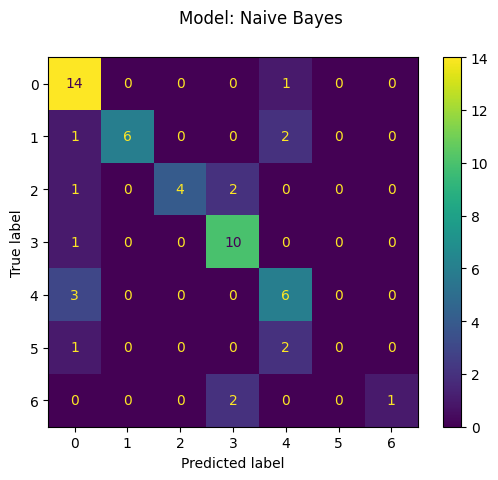

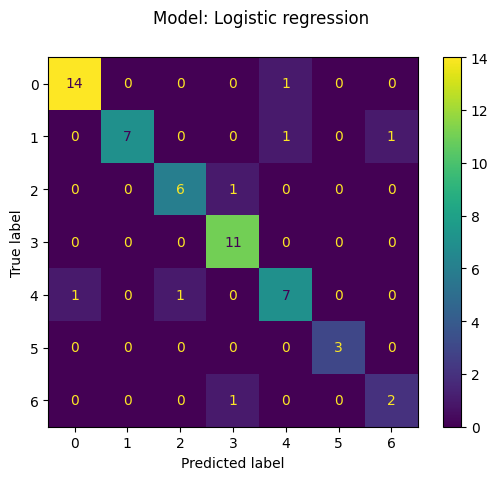

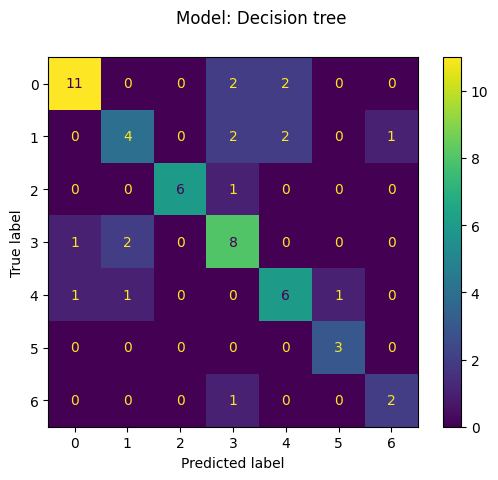

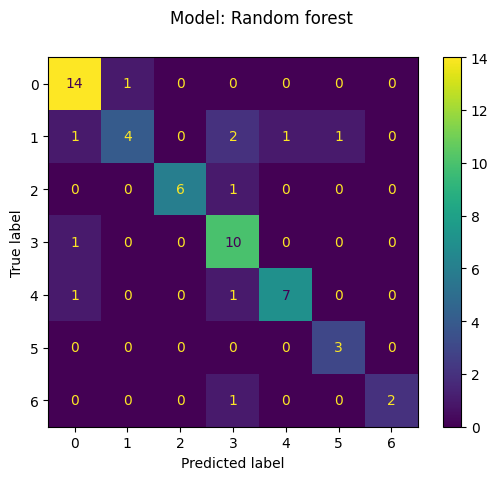

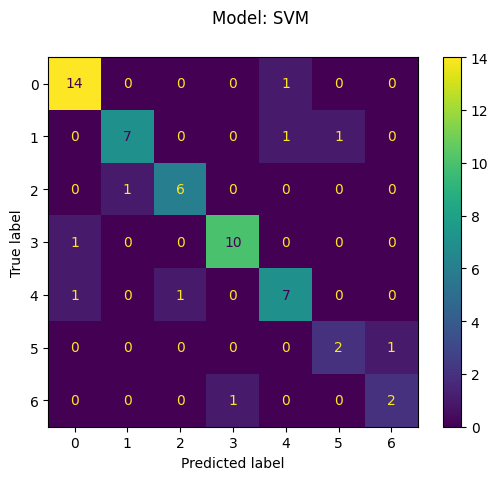

+----+---------------------+------------------+-----------------+-------------------+------------------+
|    | Model               |   Train_accuracy |   Test_accuracy |   Train_precision |   Test_precision |
+====+=====================+==================+=================+===================+==================+
|  0 | Naive Bayes         |         0.707965 |        0.719298 |          0.675467 |         0.703772 |
+----+---------------------+------------------+-----------------+-------------------+------------------+
|  1 | Logistic regression |         0.79646  |        0.877193 |          0.829135 |         0.868725 |
+----+---------------------+------------------+-----------------+-------------------+------------------+
|  2 | Decision tree       |         1        |        0.701754 |          1        |         0.715097 |
+----+---------------------+------------------+-----------------+-------------------+------------------+
|  3 | Random forest       |         1        |        

In [ ]:
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_training_and_experiment_single_label(xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order):

  model_name, train_accuracy, test_accuracy, test_precision, train_precision = [],[],[],[],[]
  for key, model in {"Naive Bayes":MultinomialNB(), "Logistic regression":LogisticRegression(), 
                     "Decision tree":DecisionTreeClassifier(), "Random forest":RandomForestClassifier(),
                     "SVM":SVC(kernel='rbf', probability=True)}.items():
    model.fit(xtrain,ytrain_label)

    pred_label_train = model.predict(xtrain)
    pred_label_test = model.predict(xtest)

    #pred_train_orders = get_predicted_orders(pred_proba_train)
    #skpred_test_orders = get_predicted_orders(pred_proba_test)
    
    model_acc_train = accuracy_score(ytrain_label,pred_label_train)
    model_acc_test = accuracy_score(ytest_label,pred_label_test)

    model_pre_train = precision_score(ytrain_label,pred_label_train,average='macro')
    model_pre_test = precision_score(ytest_label,pred_label_test,average='macro')

    cm = confusion_matrix(ytest_label,pred_label_test)
    disp = ConfusionMatrixDisplay(cm)
   # plot_confusion_matrix(model, xtest, ytest_lable) 

    disp.plot()
    plt.suptitle(f"Model: {key}")
    plt.show()

    model_name.append(key)
    train_accuracy.append(model_acc_train)
    test_accuracy.append(model_acc_test)
    train_precision.append(model_pre_train)
    test_precision.append(model_pre_test)

  model_res_df = pd.DataFrame()
  model_res_df['Model'] = model_name
  model_res_df['Train_accuracy'] = train_accuracy
  model_res_df['Test_accuracy'] = test_accuracy

  model_res_df['Train_precision'] = train_precision
  model_res_df['Test_precision'] = test_precision

  print(tabulate(model_res_df, headers = 'keys', tablefmt = 'grid'))
  return

model_training_and_experiment_single_label(xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order)

In [ ]:
import collections
collections.Counter(ytest_label)

Counter({4: 11, 3: 7, 5: 9, 1: 15, 2: 9, 6: 3, 7: 3})

In [ ]:
# hyperparameter tunning for single winner prediction

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

def hp_tunning_for_label_prediction(final_model,xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order):

  model = final_model
  param_dict = {'penalty':['l1', 'l2', 'elasticnet'],
                'C':[0.1,0.2,0.5,2,3,4,5,6,7,8,9],
                "fit_intercept":[True, False],
                'class_weight':['balanced',None]}

  para_combo_lst = list(ParameterGrid(param_dict))
  train_accuracy, test_accuracy = [],[]
  model_res_df = pd.DataFrame(columns=["C",'penalty','fit_intercept','class_weight'])

  for combo in para_combo_lst:
    
    if combo['penalty'] == "elasticnet":

      model = model.set_params(penalty=combo['penalty'],C=combo['C'],fit_intercept=combo['fit_intercept'],class_weight=combo['class_weight'],solver='saga',l1_ratio=0.4)
    else:
      model = model.set_params(penalty=combo['penalty'],C=combo['C'],fit_intercept=combo['fit_intercept'],class_weight=combo['class_weight'],solver='saga')

    model.fit(xtrain,ytrain_label)

    pred_label_train = model.predict(xtrain)
    pred_label_test = model.predict(xtest)

    model_pre_train = precision_score(ytrain_label,pred_label_train,average='macro')
    model_pre_test = precision_score(ytest_label,pred_label_test,average='macro')

   # model_name.append(key)
    train_accuracy.append(model_pre_train)
    test_accuracy.append(model_pre_test)
    model_res_df = model_res_df.append(combo,ignore_index=True)

  model_res_df['Train_precision'] = train_accuracy
  model_res_df['Validation_precision'] = test_accuracy

  model_res_df = model_res_df.sort_values(by=['Validation_precision',"Train_precision"],ascending=[False,False]).reset_index(drop=True)

  print(tabulate(model_res_df, headers = 'keys', tablefmt = 'grid'))
  return model_res_df

hp_tunning_df_for_label = hp_tunning_for_label_prediction(LogisticRegression(),xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order)

+-----+-----+------------+-----------------+----------------+-------------------+------------------------+
|     |   C | penalty    | fit_intercept   | class_weight   |   Train_precision |   Validation_precision |
+=====+=====+============+=================+================+===================+========================+
|   0 | 0.5 | elasticnet | True            |                |          0.827612 |               0.868725 |
+-----+-----+------------+-----------------+----------------+-------------------+------------------------+
|   1 | 0.5 | elasticnet | False           |                |          0.827612 |               0.868725 |
+-----+-----+------------+-----------------+----------------+-------------------+------------------------+
|   2 | 0.5 | l2         | True            |                |          0.820452 |               0.868725 |
+-----+-----+------------+-----------------+----------------+-------------------+------------------------+
|   3 | 0.5 | l2         | False     

In [ ]:
def label_predictor(election_data):

  if election_data.isnull().sum().sum() != 0:
    print("Found missing values in election data, please cheak the data")
    return

  else:

    final_model = get_final_model(hp_tunning_df_for_label,xtrain,ytrain_label)
    
    df_after_fe = fe_process(election_data)
    election_result = final_model.predict(df_after_fe)
  
  return f"Winner of election is Candidate {election_result[0]}"

In [ ]:
#final result
label_predictor(df_7cand_data_new)

'Winner of election is Candidate 1'

## Experiments Section

In [ ]:
# intial experiments using borda counts

import timeit
def borda_count(df,num_candidates):                   # gives borda scores
 # startTime = timeit.default_timer()   
  data = df.copy()
  cl = list(data.columns)
  cl.remove('Number of Voters')
  
  for cand in cl:
    data[cand+'score'] = data['Number of Voters'] * ((num_candidates+1) - data[cand])

  score_dict = {}

  for cand in cl:
    score_dict[cand] = np.sum(data[cand+'score'].values)
  rd = sorted(score_dict.items(),key=lambda x:x[1],reverse=True)
 # endTime = timeit.default_timer()
  #time_taken = endTime - startTime
  return rd


In [ ]:
# data preparation for deep learning experiments

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np

ytrain_label_dl = ytrain_label-1
ytest_label_dl = ytest_label-1
ytraindl = tf.keras.utils.to_categorical(ytrain_label_dl,num_classes=7)
ytestdl = tf.keras.utils.to_categorical(ytest_label_dl,num_classes=7)

ytrain_or_dl = np.array([lst for lst in ytrain_order])
ytest_or_dl = np.array([lst for lst in ytest_order])

# Deep Learning experiments

input = Input(shape=(7,))

l01 = Dense(units=500,activation='relu')(input)
do = Dropout(rate=0.5)(l01)
l02 = Dense(units=400)(do)
do1 = Dropout(rate=0.5)(l02)
l0 = Dense(units=200,activation='relu')(do1)
do2 = Dropout(rate=0.4)(l0)
l1 = Dense(units=100,activation='relu')(do2)
#l2 = Dense(units=2)(l01)
do2 = Dropout(rate=0.4)(l1)
l12 = Dense(units=50,activation='relu')(do2)
l3 = Dense(units=30,activation='relu')(l12)
fin = Dense(units=30)(l3)
out = Dense(units=7)(fin)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/best_dl_model.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model = Model(inputs=[input],outputs=out)
model.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
model.fit(xtrain,ytrain_or_dl,batch_size=8,epochs=1000
          ,validation_data=(xtest,ytest_or_dl),callbacks=[model_checkpoint_callback])


Epoch 1/1000
29/29 [==============================] - 2s 17ms/step - loss: 2.5504 - accuracy: 0.2434 - val_loss: 1.8233 - val_accuracy: 0.1579
Epoch 2/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.8998 - accuracy: 0.1770 - val_loss: 1.9969 - val_accuracy: 0.1579
Epoch 3/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.8809 - accuracy: 0.1903 - val_loss: 1.9491 - val_accuracy: 0.1579
Epoch 4/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.8546 - accuracy: 0.1637 - val_loss: 1.8713 - val_accuracy: 0.1579
Epoch 5/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.8287 - accuracy: 0.2080 - val_loss: 2.0673 - val_accuracy: 0.1579
Epoch 6/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.8041 - accuracy: 0.2257 - val_loss: 1.9561 - val_accuracy: 0.1579
Epoch 7/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.8030 - accuracy: 0.1637 - val_loss: 1.8602 - val_accuracy: 0.1579
Epo

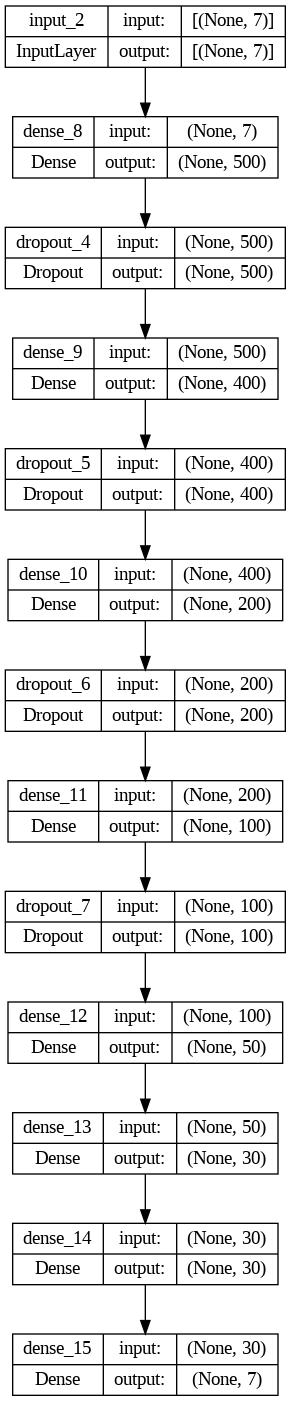

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Deep Learning model evaluation

from keras.models import load_model
import scipy.stats as ss
model = load_model("/content/best_dl_model.h5")

#dl orders pred result
pred_ord_dl = model.predict(xtest)
def get_dl_orders(pred_ord_dl):
  result_lst = []
  for pred in pred_ord_dl:
    res = ss.rankdata(pred)
    result_lst.append(res)
  return result_lst

final_dl_ord = get_dl_orders(pred_ord_dl)

acc = get_accuracy(ytest_order,final_dl_ord)
print(f"Accuracy of deep learning model in predicting orders: {acc}")

2/2 [==============================] - 0s 7ms/step
Accuracy of deep learning model in predicting orders: 37.092731829573935


# Conclusion and Observations

In [ ]:
conclusion_df = pd.DataFrame()
conclusion_df['Method'] = ['Kemeny young method',"ML Model"]
conclusion_df['Execution_time'] = ["1 to 1.5 Minutes","0.05 to 0.1 Second"]
conclusion_df['Accuracy'] = ["-","Multi Winner = 60% || Single Winner = 86%"]
conclusion_df['Conclusion'] = ["ML model is 1000x faster than Kemeny young method", ""]
print(tabulate(conclusion_df, headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═════════════════════╤════════════════════╤═══════════════════════════════════════════╤═══════════════════════════════════════════════════╕
│    │ Method              │ Execution_time     │ Accuracy                                  │ Conclusion                                        │
╞════╪═════════════════════╪════════════════════╪═══════════════════════════════════════════╪═══════════════════════════════════════════════════╡
│  0 │ Kemeny young method │ 1 to 1.5 Minutes   │ -                                         │ ML model is 1000x faster than Kemeny young method │
├────┼─────────────────────┼────────────────────┼───────────────────────────────────────────┼───────────────────────────────────────────────────┤
│  1 │ ML Model            │ 0.05 to 0.1 Second │ Multi Winner = 60% || Single Winner = 86% │                                                   │
╘════╧═════════════════════╧════════════════════╧═══════════════════════════════════════════╧═══════════════════════════════

# Building Predictor for any Number of candidates

In [ ]:
#inputs

ele_data = pd.read_csv('/content/drive/MyDrive/soi.csv')
NUM_candidates = 5
NUM_voters_col = "Number of Voters"

####

import warnings
warnings.filterwarnings("ignore")


ele_data = ele_data.dropna()
ele_data = ele_data.astype('int')
ele_data = ele_data.reset_index(drop=True)
df_7cand_data_any = preference_to_candidate(ele_data)

df_lst_any = generate_chunks(df_7cand_data_any,5)

labels_lst_any, orders_lst_any = gen_target_and_orders(df_lst_any)

df_final = get_final_df(df_lst_any,labels_lst_any,orders_lst_any)


from sklearn.model_selection import train_test_split

x = df_final.drop(columns=['target'])
y = df_final['target'].values

xtrain,xtest,ytrain_label,ytest_label = train_test_split(x,y,test_size=0.2,stratify=y,random_state=36)

ytrain_order = xtrain['orders'].values
ytest_order = xtest['orders'].values

xtrain = xtrain.drop(columns=['orders'])
xtest = xtest.drop(columns=['orders'])

# model training and experiments

# hyperparameter tunning for multi winner prediction
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

def hp_tunning_for_order_prediction(final_model,xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order):

  model = final_model
  param_dict = {'penalty':['l1', 'l2', 'elasticnet'],
                'C':[0.1,0.2,0.5,2,3,4,5,6,7,8,9],
                "fit_intercept":[True, False],
                'class_weight':['balanced',None]}

  para_combo_lst = list(ParameterGrid(param_dict))
  train_accuracy, test_accuracy = [],[]
  model_res_df = pd.DataFrame(columns=["C",'penalty','fit_intercept','class_weight'])

  for combo in para_combo_lst:
    
    if combo['penalty'] == "elasticnet":

      model = model.set_params(penalty=combo['penalty'],C=combo['C'],fit_intercept=combo['fit_intercept'],class_weight=combo['class_weight'],solver='saga',l1_ratio=0.4)
    else:
      model = model.set_params(penalty=combo['penalty'],C=combo['C'],fit_intercept=combo['fit_intercept'],class_weight=combo['class_weight'],solver='saga')

    model.fit(xtrain,ytrain_label)
    pred_proba_train = model.predict_proba(xtrain)
    pred_proba_test = model.predict_proba(xtest)

    pred_train_orders = get_predicted_orders(pred_proba_train)
    pred_test_orders = get_predicted_orders(pred_proba_test)
    
    model_acc_train = get_accuracy(ytrain_order,pred_train_orders)
    model_acc_test = get_accuracy(ytest_order,pred_test_orders)

   # model_name.append(key)
    train_accuracy.append(model_acc_train)
    test_accuracy.append(model_acc_test)
    model_res_df = model_res_df.append(combo,ignore_index=True)

  model_res_df['Train_accuracy'] = train_accuracy
  model_res_df['Validation_accuracy'] = test_accuracy

  model_res_df = model_res_df.sort_values(by=['Validation_accuracy',"Train_accuracy"],ascending=[False,False]).reset_index(drop=True)

  #print(tabulate(model_res_df, headers = 'keys', tablefmt = 'grid'))
  return model_res_df

hp_tunning_df_for_order_any = hp_tunning_for_order_prediction(LogisticRegression(),xtrain,xtest,ytrain_label,ytest_label,ytrain_order,ytest_order)


def order_predictor(election_data):

  if election_data.isnull().sum().sum() != 0:
    print("Found missing values in election data, please cheak the data")
    return

  else:

    final_model = get_final_model(hp_tunning_df_for_order_any,xtrain,ytrain_label)
    
    df_after_fe = fe_process(election_data)
    model_proba = final_model.predict_proba(df_after_fe)
    election_result = get_predicted_orders(model_proba)

    ele_res_df = pd.DataFrame(columns=['Rank', "Candidate"])
    ele_res_df['Rank'] = [ele+1 for ele in range(NUM_candidates)]
    ele_res_df['Candidate'] = ["Candidate "+str(cand) for cand in election_result[0]]

    return ele_res_df

#result


100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


In [ ]:
election_data = ele_data   #<<<-----------your election data here
order_predictor(election_data)

,Rank,Candidate
0,1,Candidate 1
1,2,Candidate 4
2,3,Candidate 3
3,4,Candidate 2
4,5,Candidate 5
